# Setup

In [70]:
import copy
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
import os
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
# Make sure you run Jupyter Notebook from project root
# DO NOT RUN MULTIPLE TIMES
%cd ..
filename = "GSE72857_accession_formatted.csv"
results_file = 'write/pbmc3k.h5ad'
if not os.path.exists('write'):
    os.makedirs('write')

C:\Users\wroej\Documents\GitHub\CS-7641-Project


In [3]:
#Code to set global figure settings (feel free to remove, I just added to make the graphs look cleaner)
sc.settings.set_figure_params(dpi=80)

In [4]:
adata = sc.read_csv(filename, first_column_names=True).T
adata

AnnData object with n_obs × n_vars = 10368 × 27297

# Preprocessing

In [5]:
count_depth = np.sum(adata.X, axis = 1)
print("count depth shape:{}".format(count_depth.shape))
#print(count_depth)
number_of_genes = np.sum(adata.X>0,axis=1)
print("number_of_genes shape:{}".format(number_of_genes.shape))
#print(number_of_genes)

count depth shape:(10368,)
number_of_genes shape:(10368,)


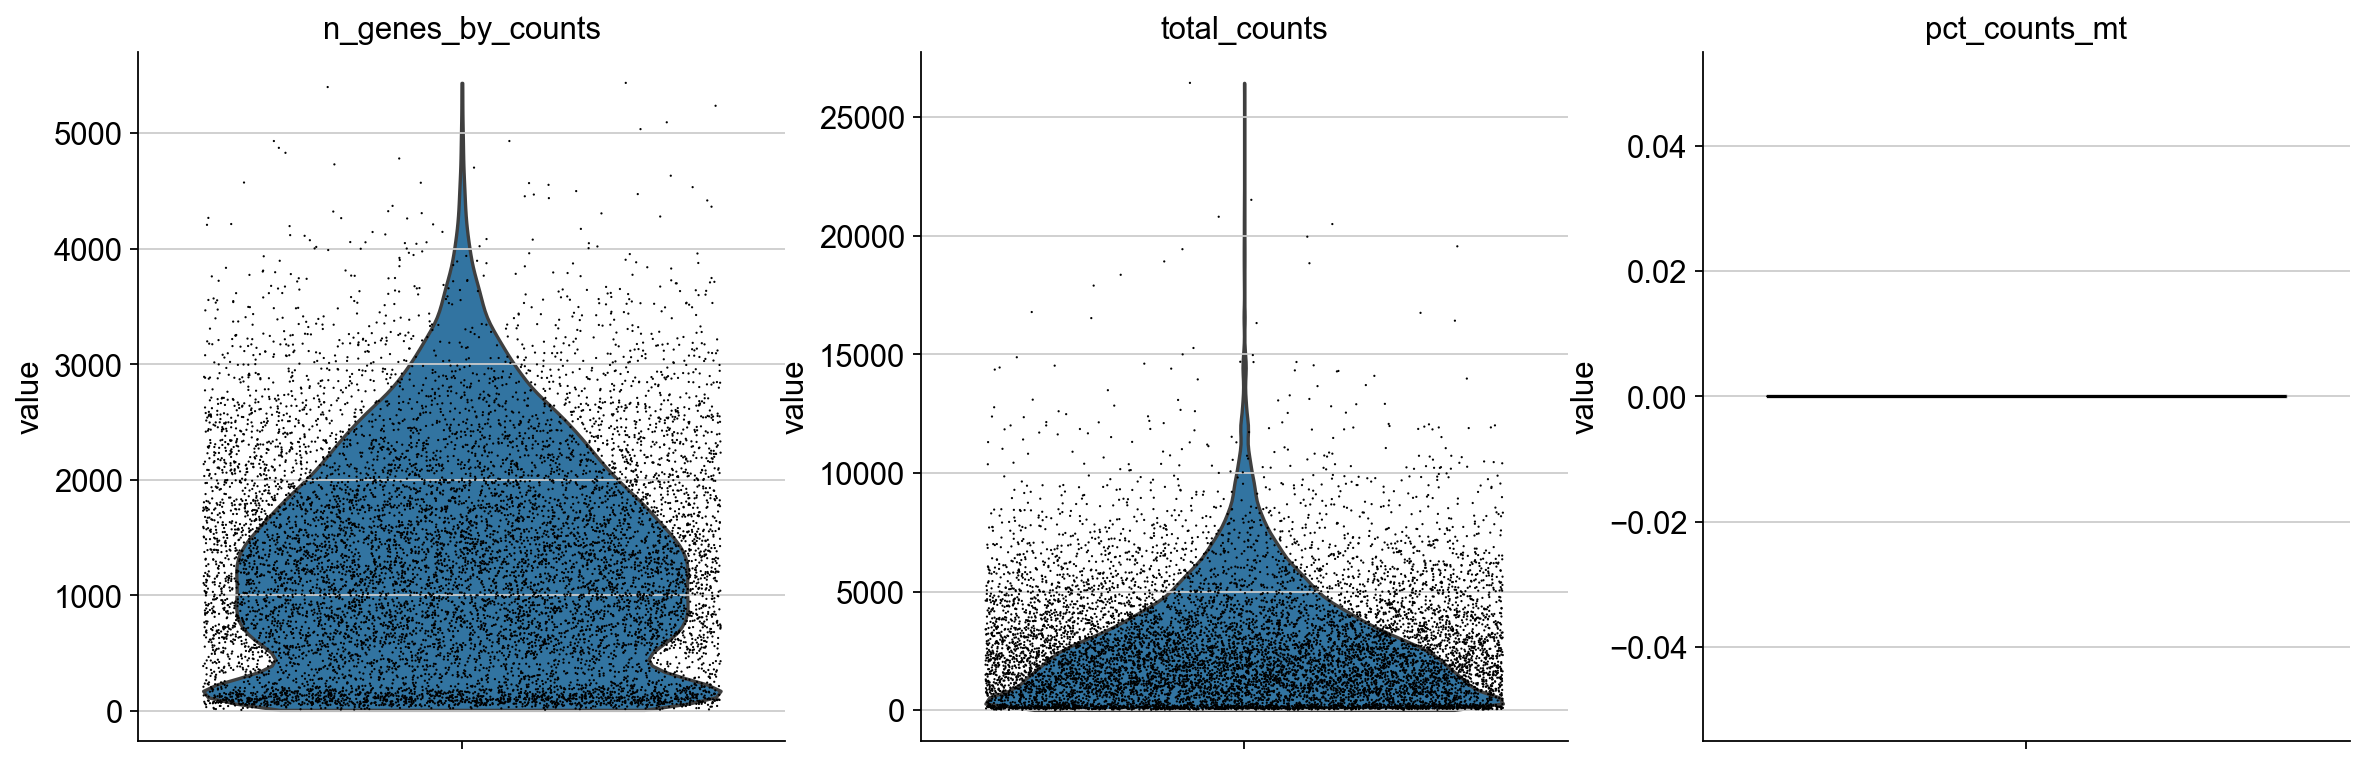

In [6]:
# when/where/why do we do violin plots? 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

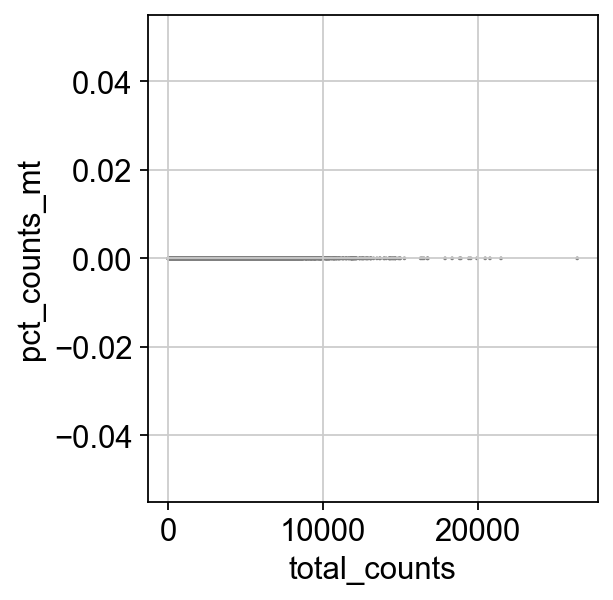

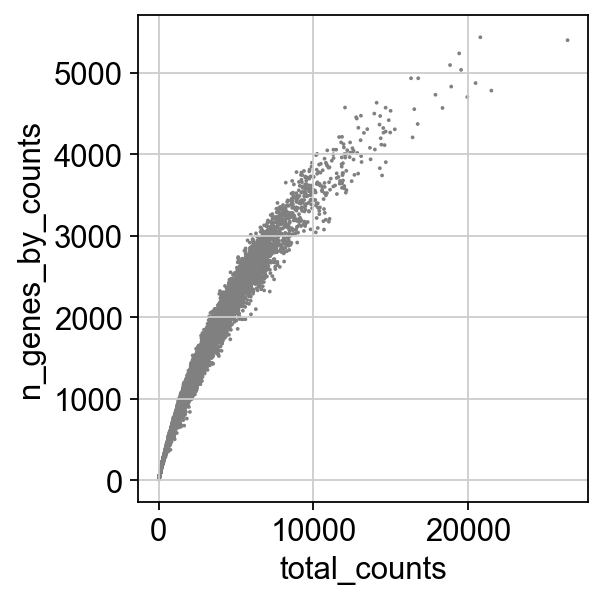

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Text(0, 0.5, 'unique genes')

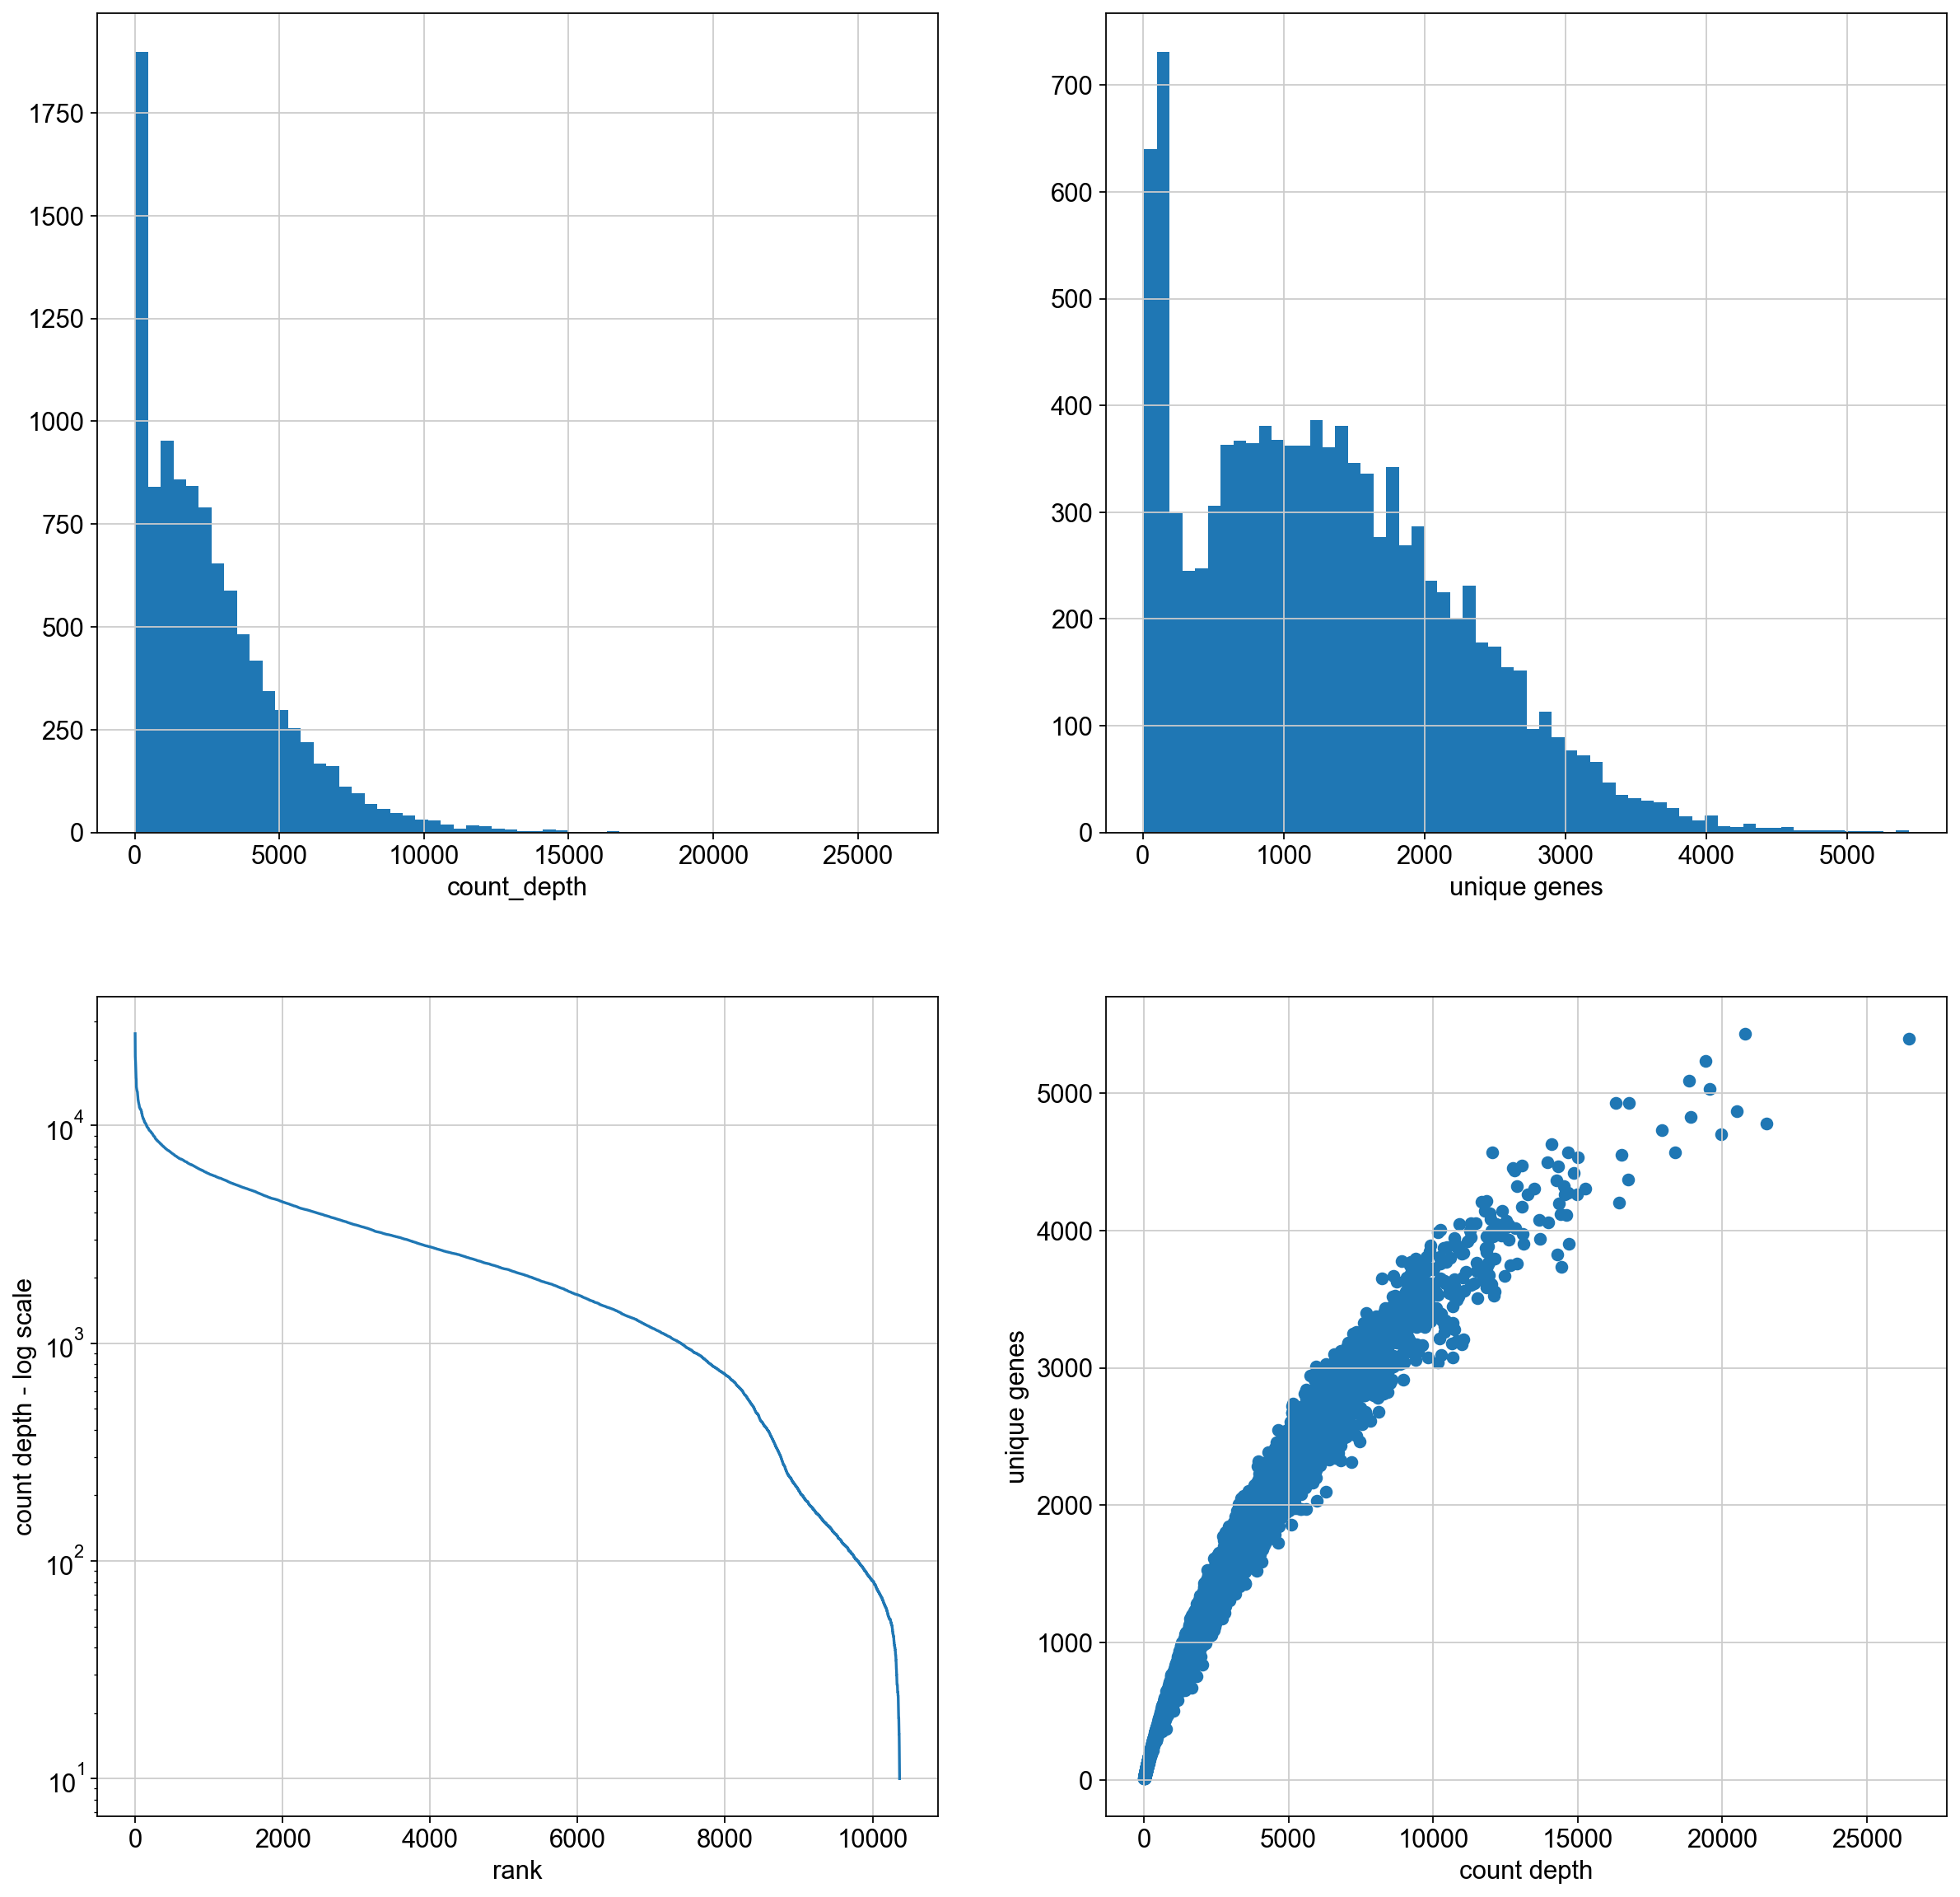

In [8]:
plt.rcParams["figure.figsize"] = [18,18]
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(count_depth,bins=60)
#axs[0,0].set_yscale("log")
axs[0,0].set_xlabel("count_depth")

axs[0,1].hist(number_of_genes,bins=60)
#axs[0,1].set_yscale("log")
axs[0,1].set_xlabel("unique genes")

axs[1,0].plot(range(len(count_depth)),sorted(count_depth,reverse=True))
axs[1,0].set_yscale("log")
axs[1,0].set_xlabel("rank")
axs[1,0].set_ylabel("count depth - log scale")

axs[1,1].scatter(count_depth,number_of_genes)
axs[1,1].set_xlabel("count depth")
axs[1,1].set_ylabel("unique genes")

Text(0.5, 0, 'unique genes')

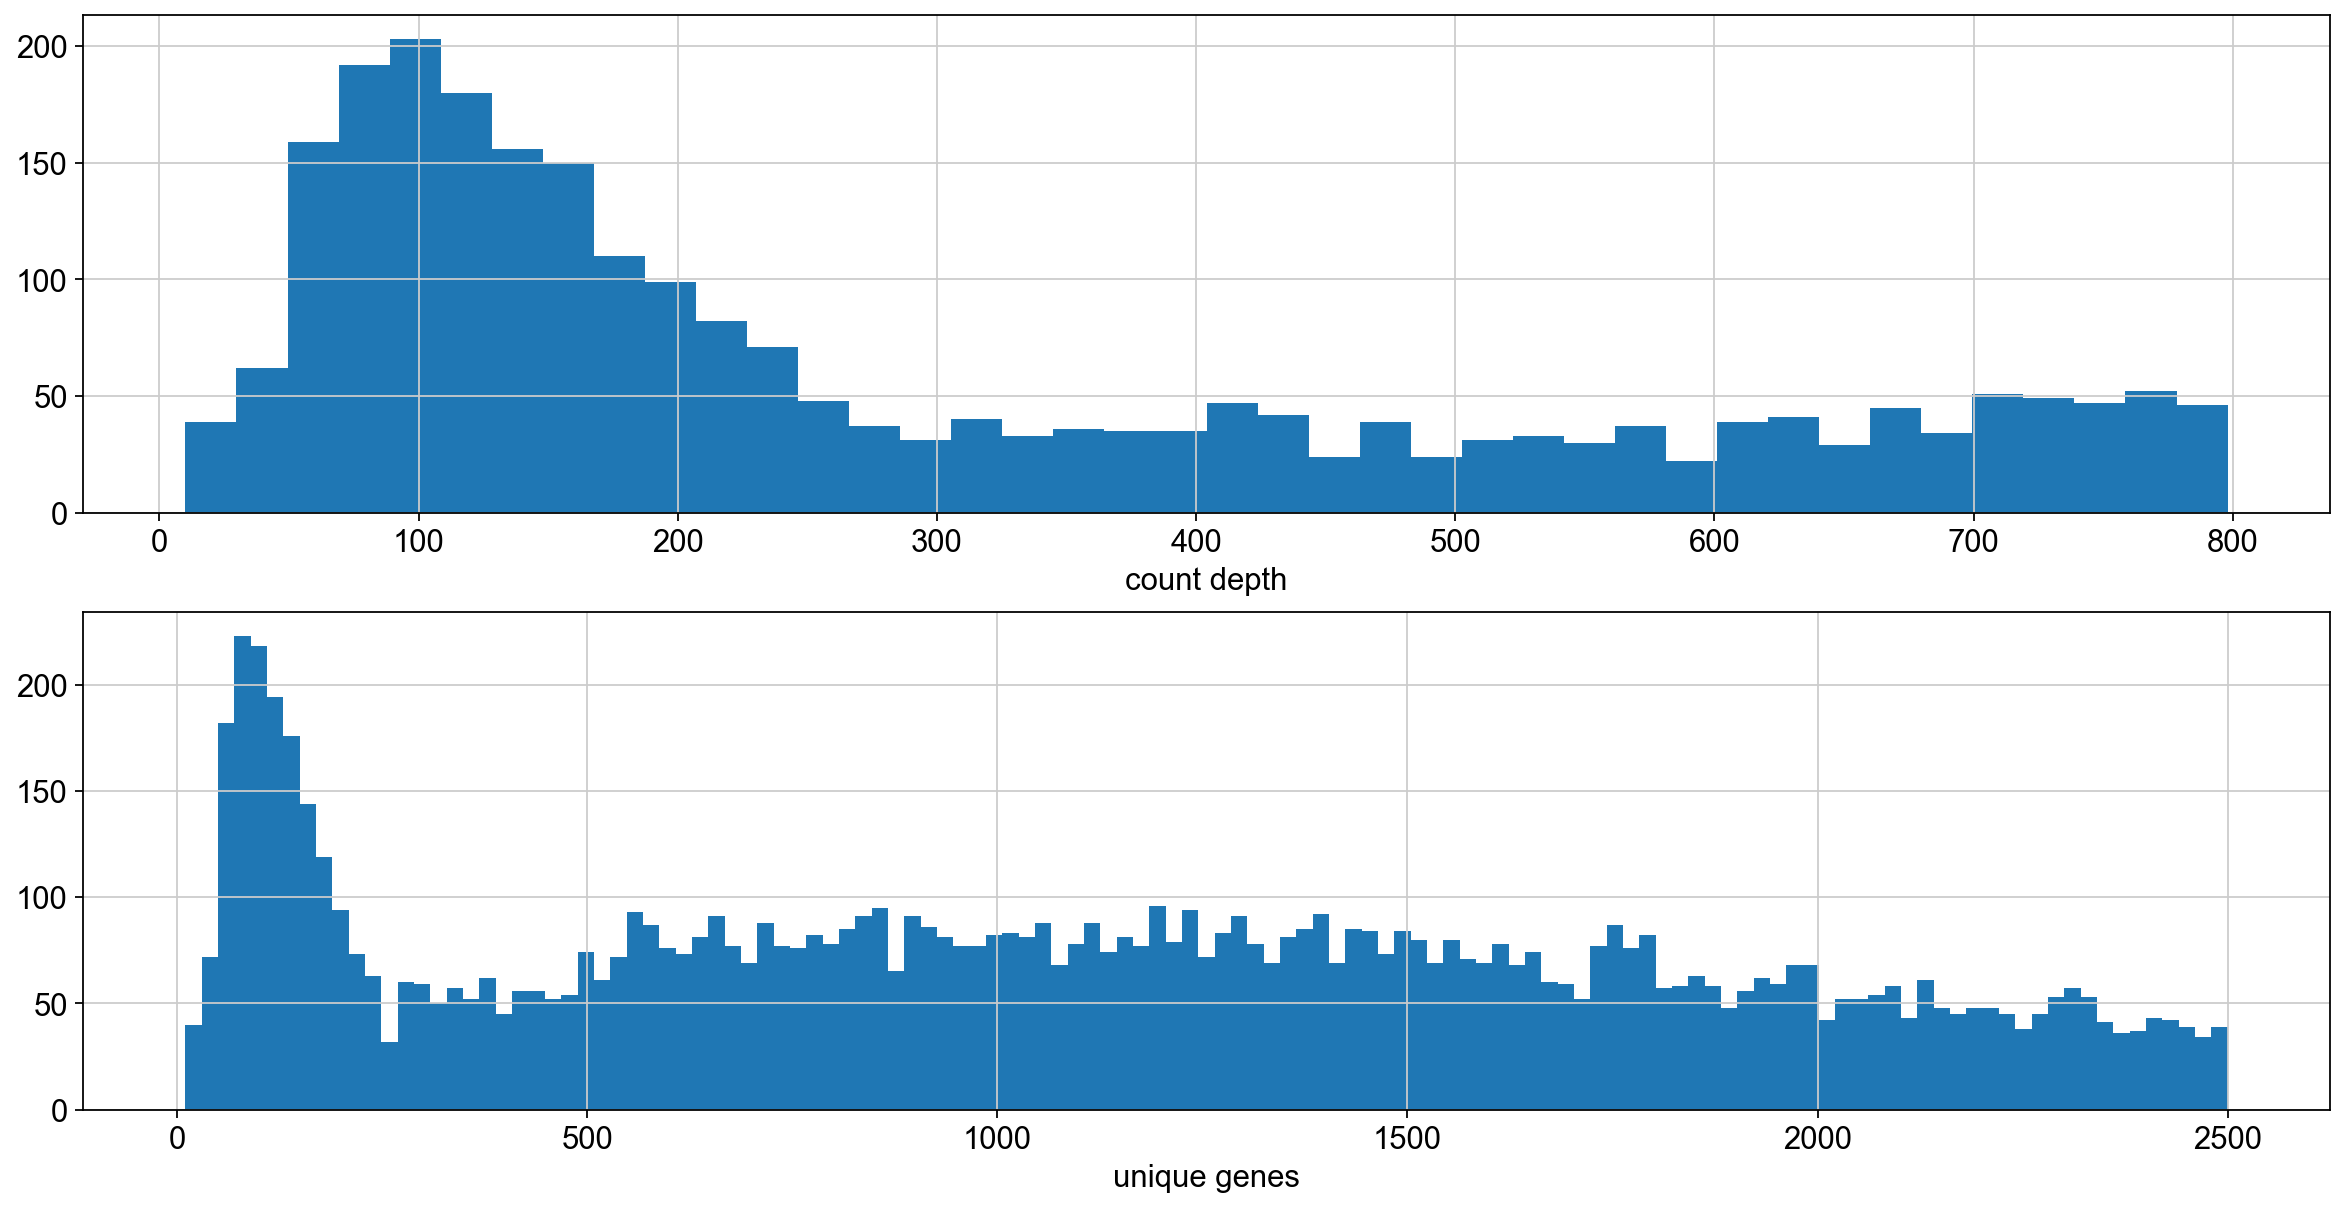

In [9]:
plt.rcParams["figure.figsize"] = [18,9]
fig2, axs2 = plt.subplots(2, 1)

mindepth = 1
maxdepth = 800
mingenes = 1
maxgenes = 2500

#axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=True)
axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=False)
#axs2[0].set_yscale("log")
axs2[0].set_xlabel("count depth")
#axs2[0].hist(count_depth[np.where((count_depth < maxdepth))], bins=21)

axs2[1].hist(number_of_genes[np.where((number_of_genes<=maxgenes) & (number_of_genes >= mingenes))],bins=min([200,int(maxgenes/20)]),cumulative=False)
#axs2[1].set_yscale("log")
axs2[1].set_xlabel("unique genes")
#axs2[1].hist(number_of_genes[np.where((number_of_genes<maxgenes) )],bins=21)

I'll have to check how this dataset was collected, but it looks like these cells may already have been FACS sorted against some kind of live/dead stain prior to scRNA-seq, they are clean and missing populations with features characteristic of lysed cells


In [22]:
adata_filtered = copy.deepcopy(adata)
print(adata_filtered.X.shape)

sc.pp.filter_genes(adata_filtered, min_counts = 1)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_counts = 300)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_genes = 500)
print(adata_filtered.X.shape)

(10368, 27297)
(10368, 16162)
(8758, 16162)
(8100, 16162)


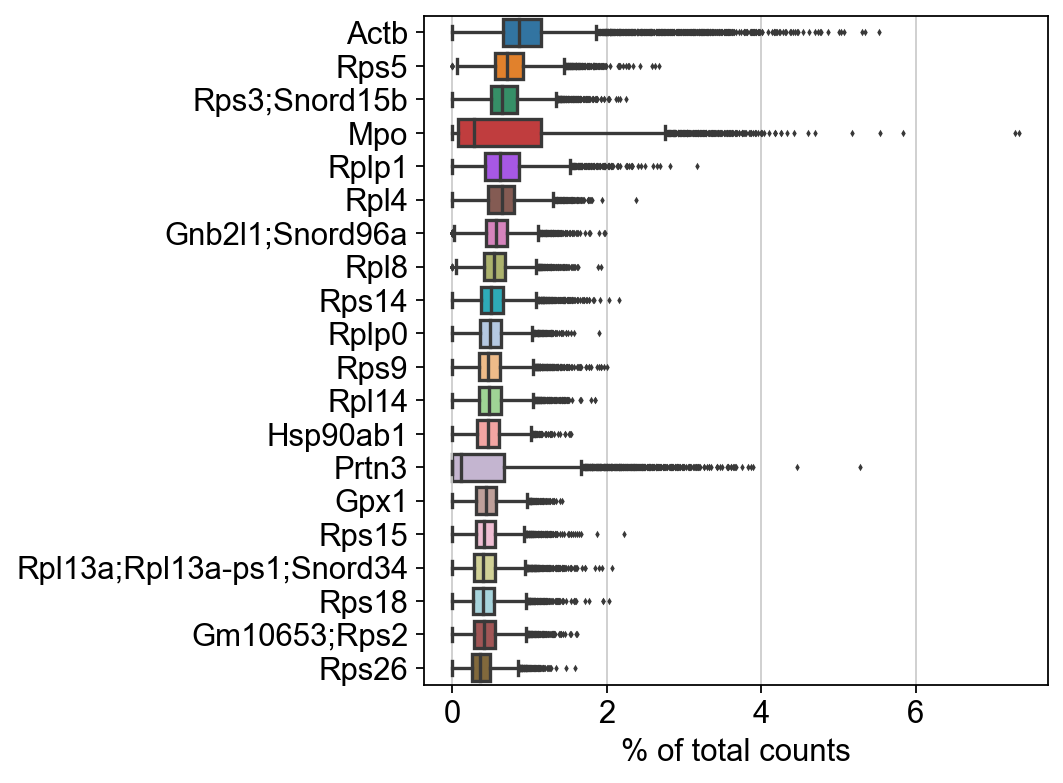

In [23]:
sc.pl.highest_expr_genes(adata_filtered, n_top=20, )

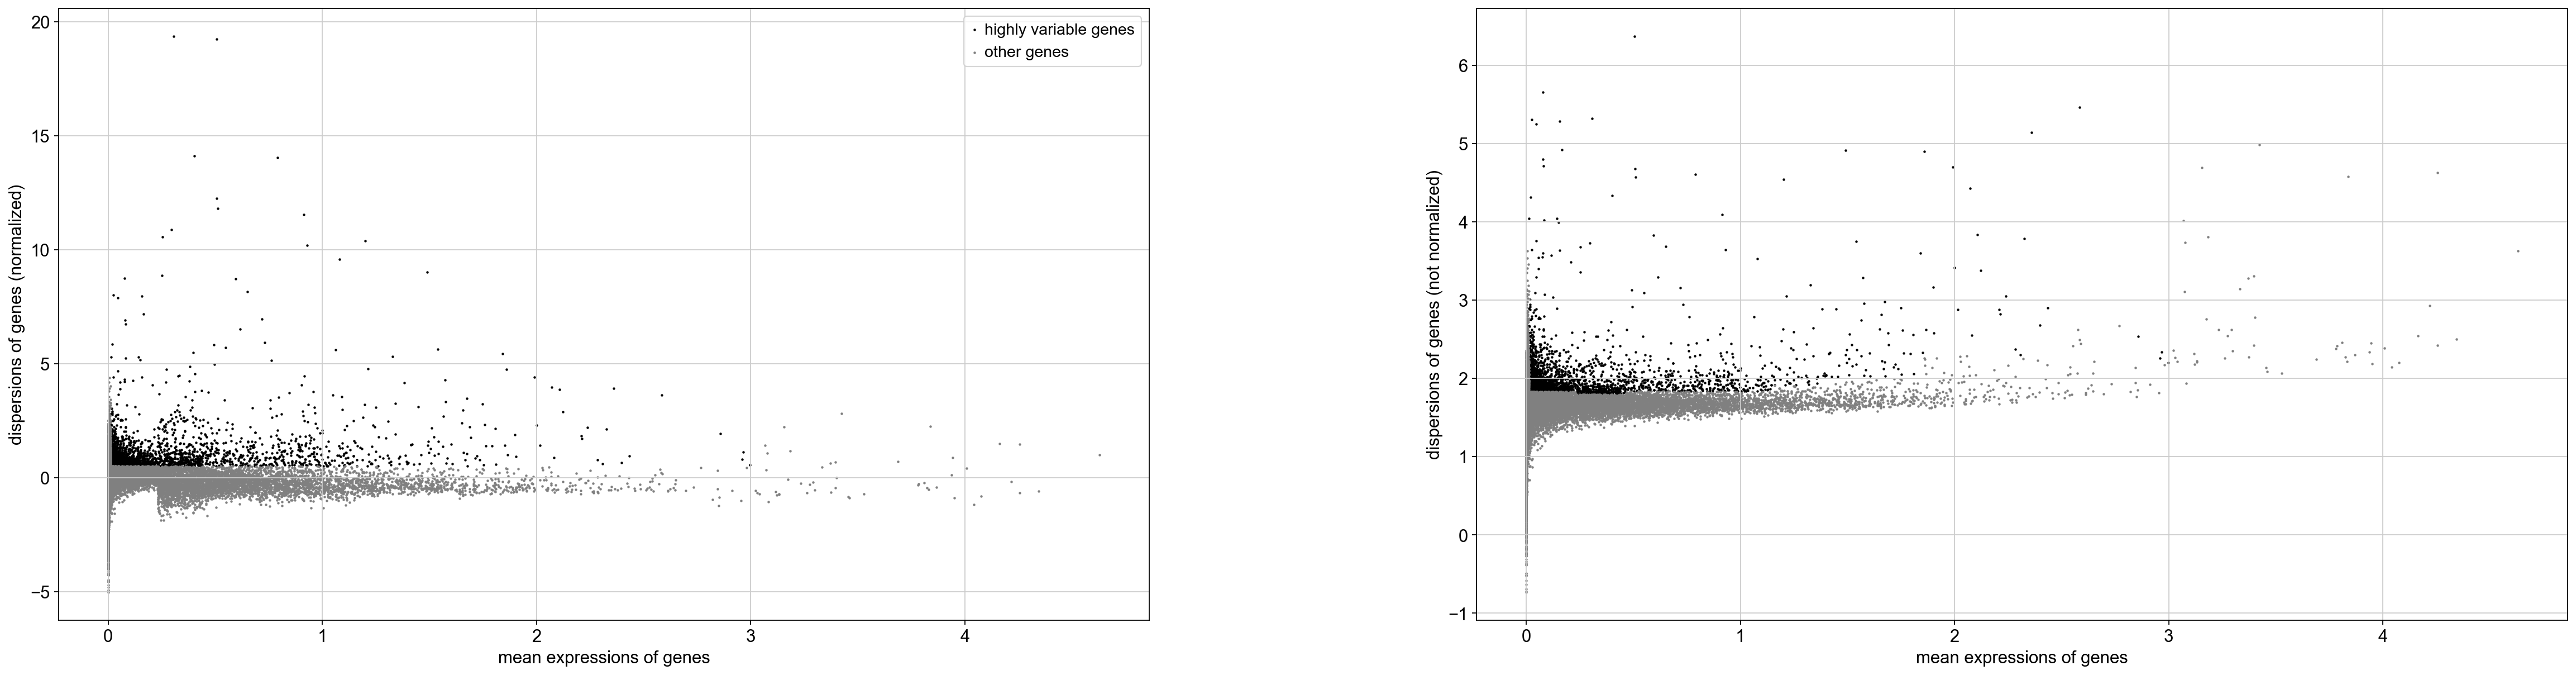

In [24]:
# within each cell, normalize count of genes to 10,000
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
# filter out any genes with less than 0.0125/10,000 mean expression AND(?) dispersion (across all cells) less than 0.5
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_filtered)
adata_filtered.raw = adata_filtered

In [25]:
filtered_copy = copy.deepcopy(adata_filtered)

In [26]:
# the lines above do not actually reduce the dataset from 16000 to 2200 genes, they just annotate var with a "highly_variabl" boolean tag, and 10 metrics of variability
adata_filtered
adata_filtered.var[adata_filtered.var['highly_variable']]

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_counts,highly_variable,means,dispersions,dispersions_norm
0610010O12Rik,False,22,0.002604,99.787809,27.0,27.0,True,0.015156,2.012001,0.895277
0910001L09Rik,False,3561,0.560764,65.653935,5814.0,5814.0,True,1.210840,1.913136,0.515169
1100001G20Rik,False,571,0.212095,94.492670,2199.0,2199.0,True,0.548973,3.093354,5.702326
1110003E01Rik,False,2517,0.358411,75.723380,3716.0,3716.0,True,0.947226,1.847298,0.589785
1110006O24Rik,False,158,0.016590,98.476080,172.0,172.0,True,0.066260,1.847201,0.539560
...,...,...,...,...,...,...,...,...,...,...
mKIAA1575;Bcor,False,1630,0.203993,84.278549,2115.0,2115.0,True,0.596376,1.849666,0.558676
mKIAA1584;Zfp280c,False,44,0.004533,99.575617,47.0,47.0,True,0.018567,1.891320,0.634791
mKIAA1994;Tsc22d1,False,1895,0.274113,81.722608,2842.0,2842.0,True,0.696258,1.869774,0.689156
slc43a2;Slc43a2,False,721,0.084587,93.045910,877.0,877.0,True,0.317229,1.800607,0.526504


# PCA

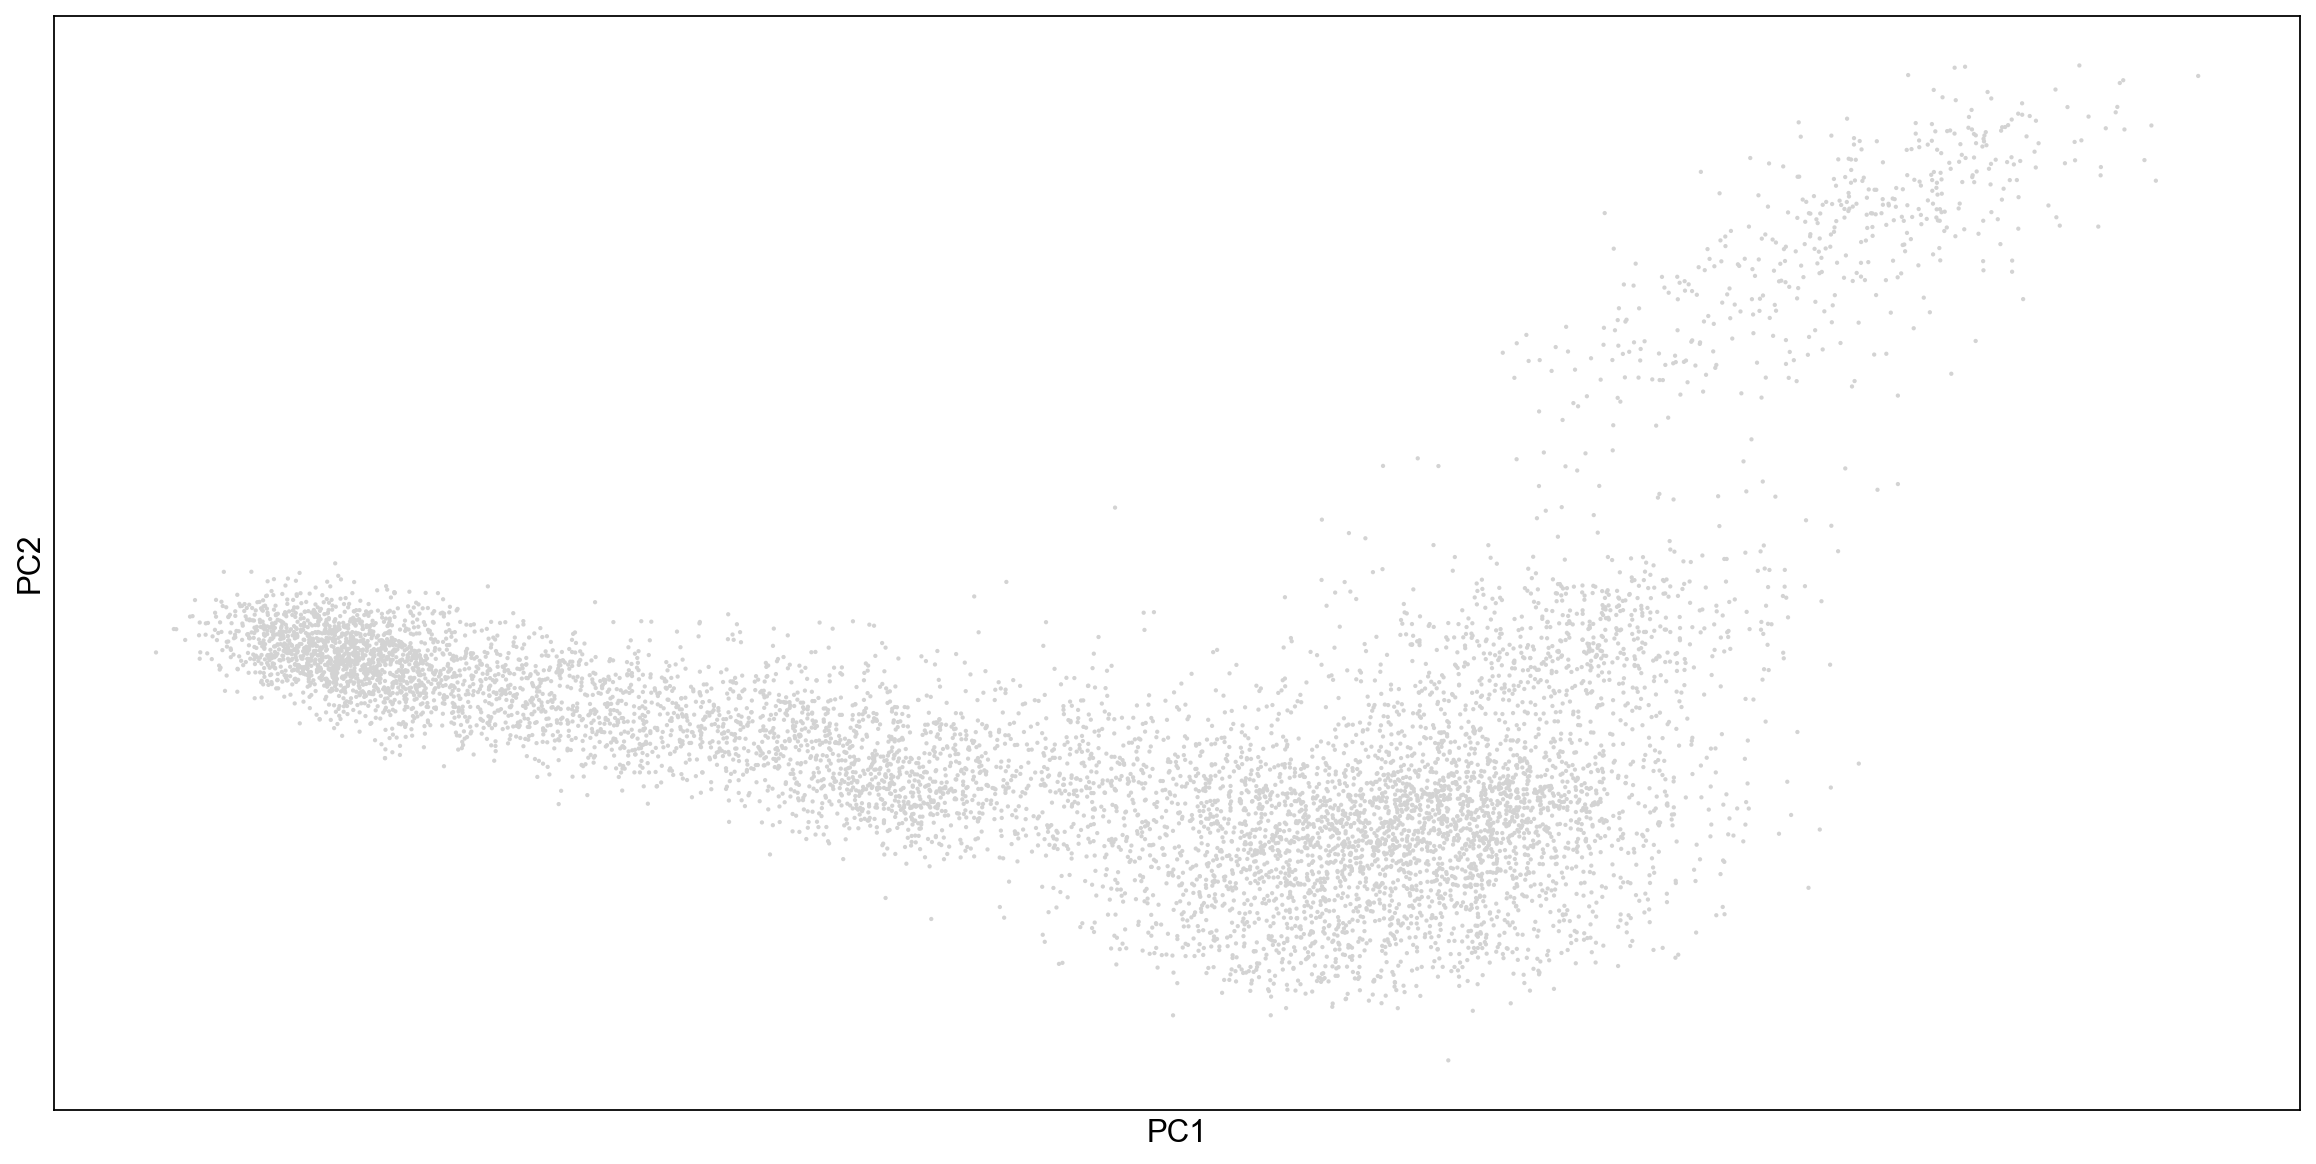

In [27]:
sc.tl.pca(adata_filtered, svd_solver='arpack') # TODO: look at 'arpack' svd solver
sc.pl.pca(adata_filtered) #, color='CST3')

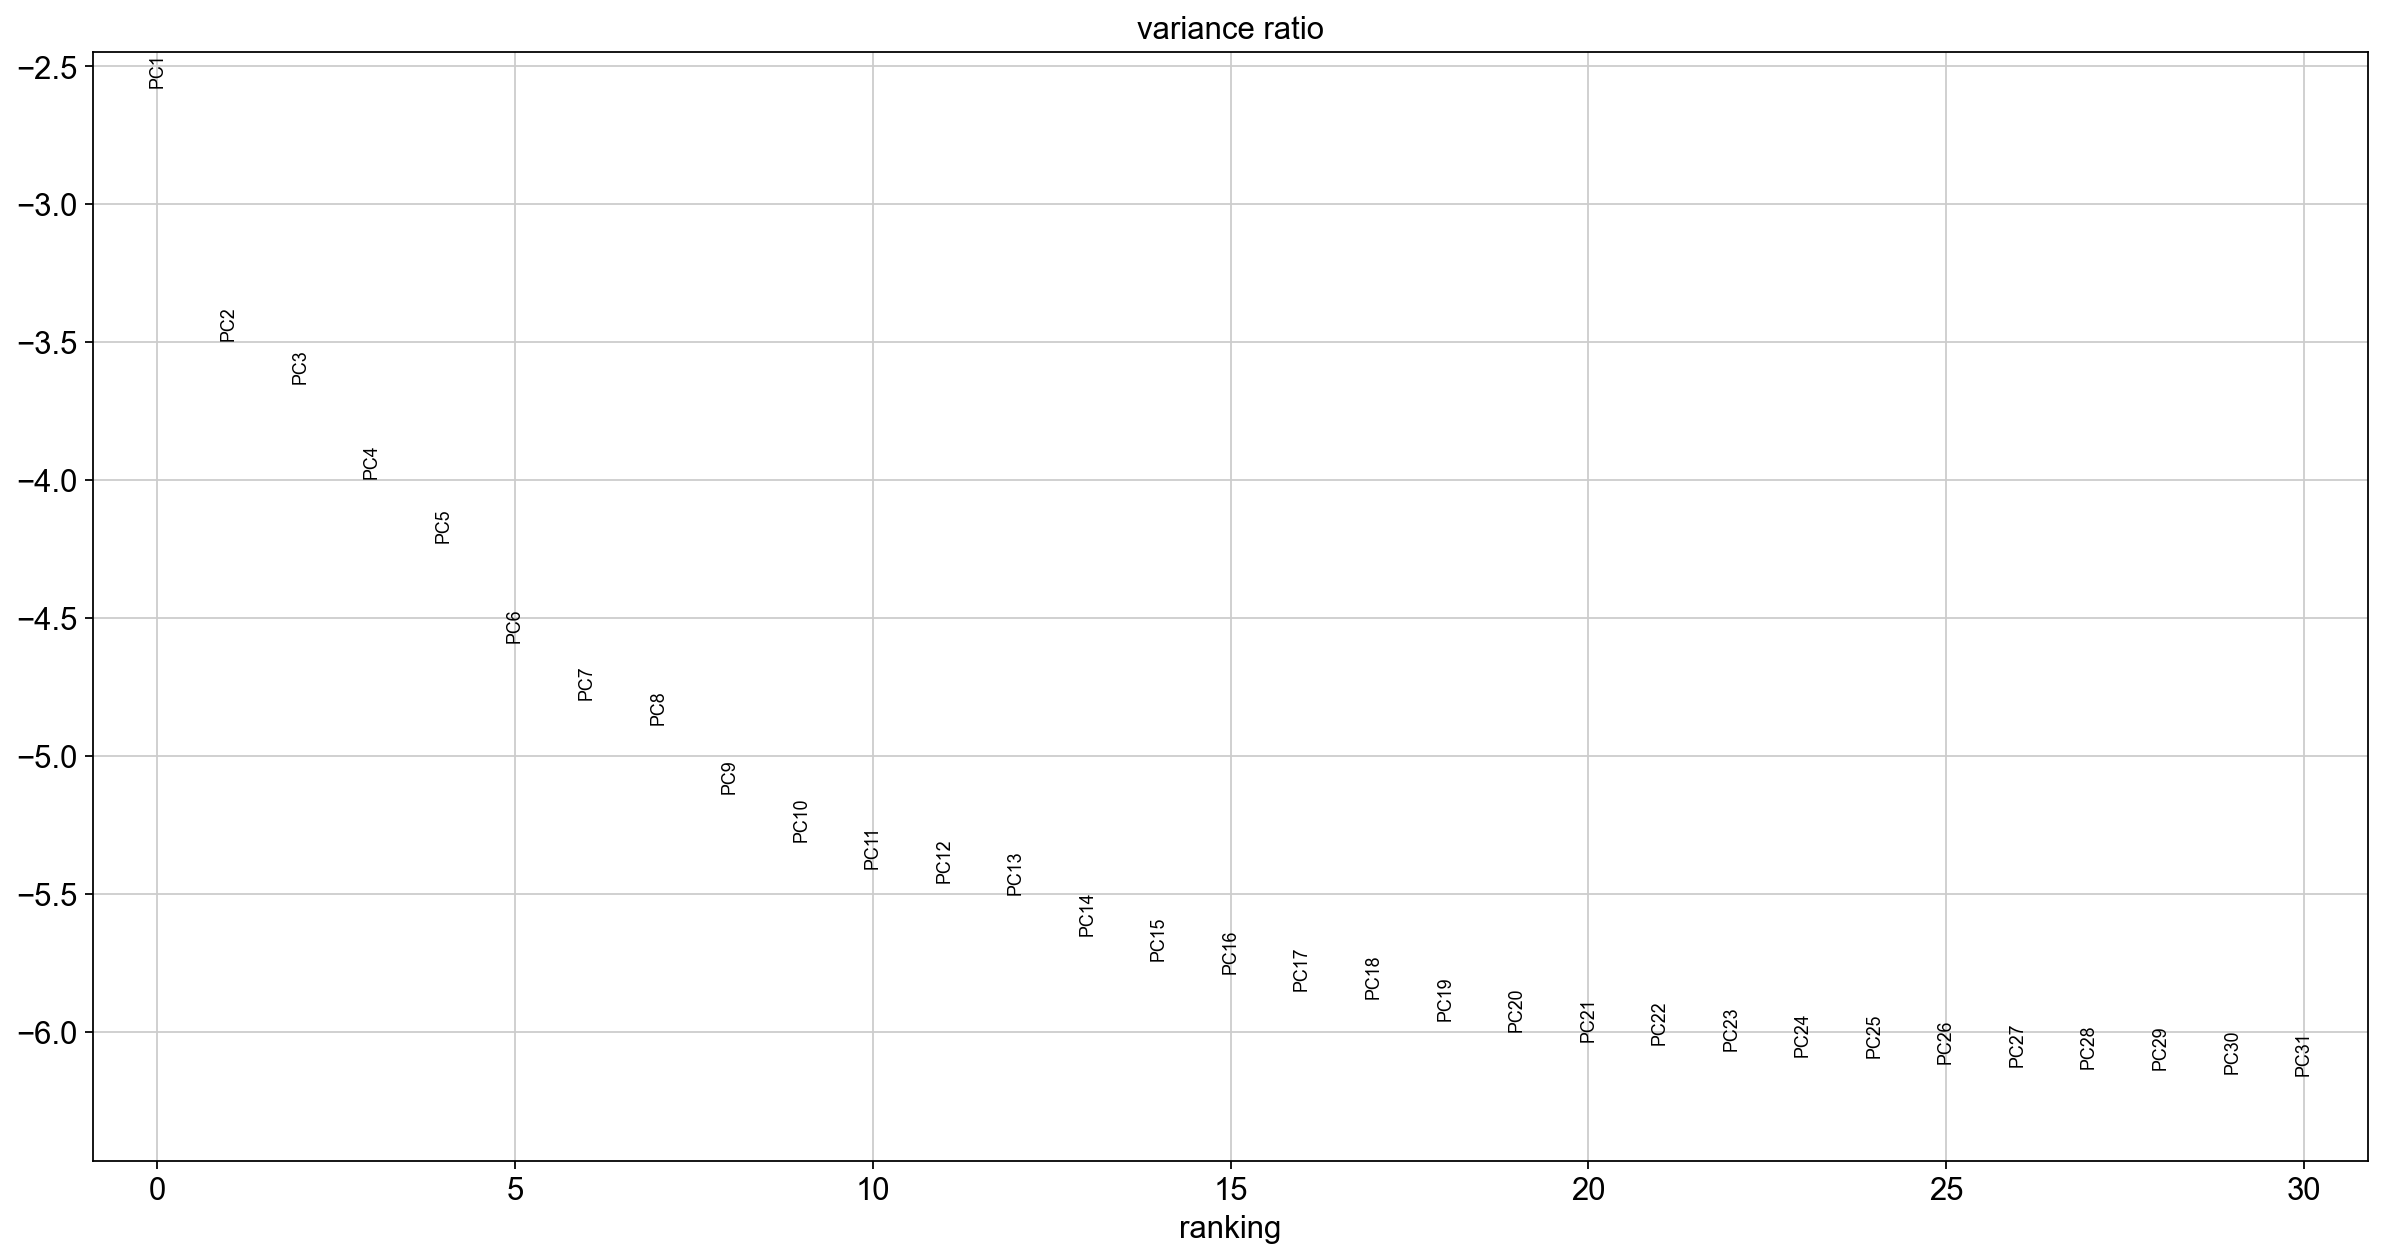

In [28]:
sc.pl.pca_variance_ratio(adata_filtered, log=True) # that's hot

In [29]:
adata_filtered.write(results_file)
adata_filtered

AnnData object with n_obs × n_vars = 8100 × 16162
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## DPT score assignment - before cell cycle regression

In [50]:
adata_filtered.uns['iroot'] = 0 
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=14, knn=True, random_state=0, method='gauss', metric='euclidean', key_added=None, copy=False)
sc.tl.dpt(adata_filtered, n_dcs=14, n_branchings=0)
adata_filtered.obs["dpt_pseudotime"]

W29954    0.000000
W29956    0.175806
W29957    0.086482
W29958    0.015406
W29960    0.018993
            ...   
W76317    0.350401
W76324    0.399524
W76331    0.194384
W76332    0.415855
W76333    0.437291
Name: dpt_pseudotime, Length: 8100, dtype: float32

Text(0, 0.5, 'dpt_score')

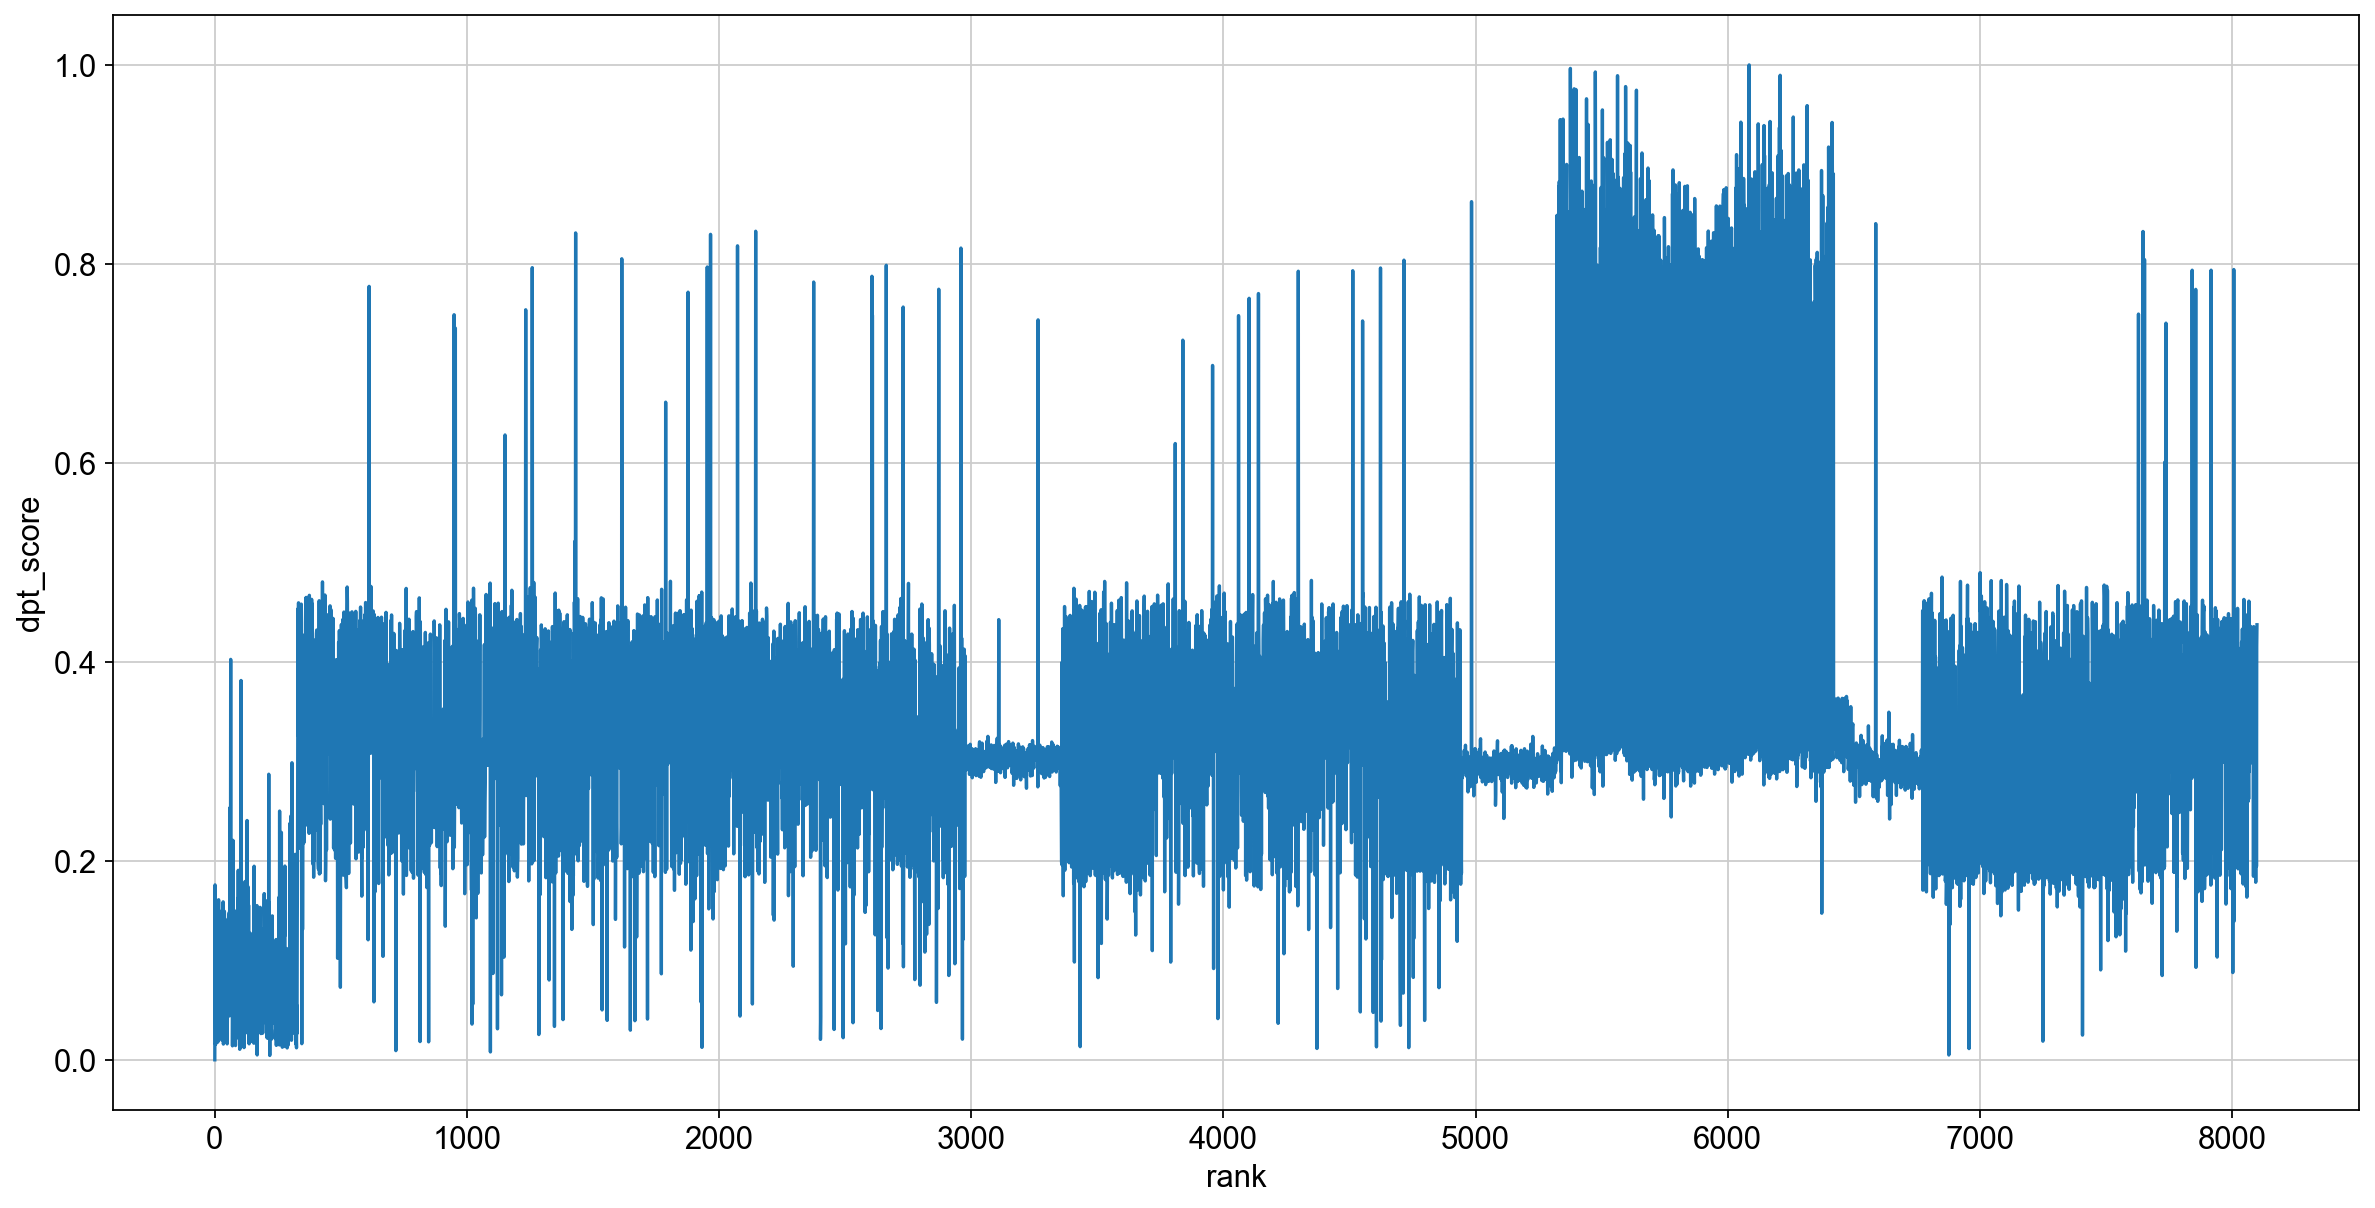

In [51]:
fig3, axs3 = plt.subplots(1, 1)

dpt_scores = list(adata_filtered.obs["dpt_pseudotime"])

axs3.plot(range(len(dpt_scores)),dpt_scores)
#axs[0].set_yscale("log")
axs3.set_xlabel("rank")
axs3.set_ylabel("dpt_score")

# Cell Cycle Regression

In [52]:
# copy_adata = copy.deepcopy(adata)
cell_cycle_file = 'cell_cycle_genes.txt'
cell_cycle_genes = [x.strip() for x in open(cell_cycle_file)]

s_genes = cell_cycle_genes[:91]
g2m_genes = cell_cycle_genes[91:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in filtered_copy.var_names]

# print(copy_adata.X.shape)
# sc.pp.filter_genes(copy_adata, min_counts = 1)
# print(copy_adata.X.shape)
# sc.pp.filter_cells(copy_adata, min_counts = 300)
# print(copy_adata.X.shape)
# sc.pp.filter_cells(copy_adata, min_genes = 500)
# print(copy_adata.X.shape)

# # within each cell, normalize count of genes to 10,000
# sc.pp.normalize_total(copy_adata, target_sum=1e4)
# sc.pp.log1p(copy_adata)
# # filter out any genes with less than 0.0125/10,000 mean expression AND(?) dispersion (across all cells) less than 0.5
# sc.pp.highly_variable_genes(copy_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(copy_adata)
# copy_adata.raw = copy_adata

sc.pp.scale(filtered_copy)
sc.tl.score_genes_cell_cycle(filtered_copy, s_genes, g2m_genes)

C:\Users\wroej\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
C:\Users\wroej\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


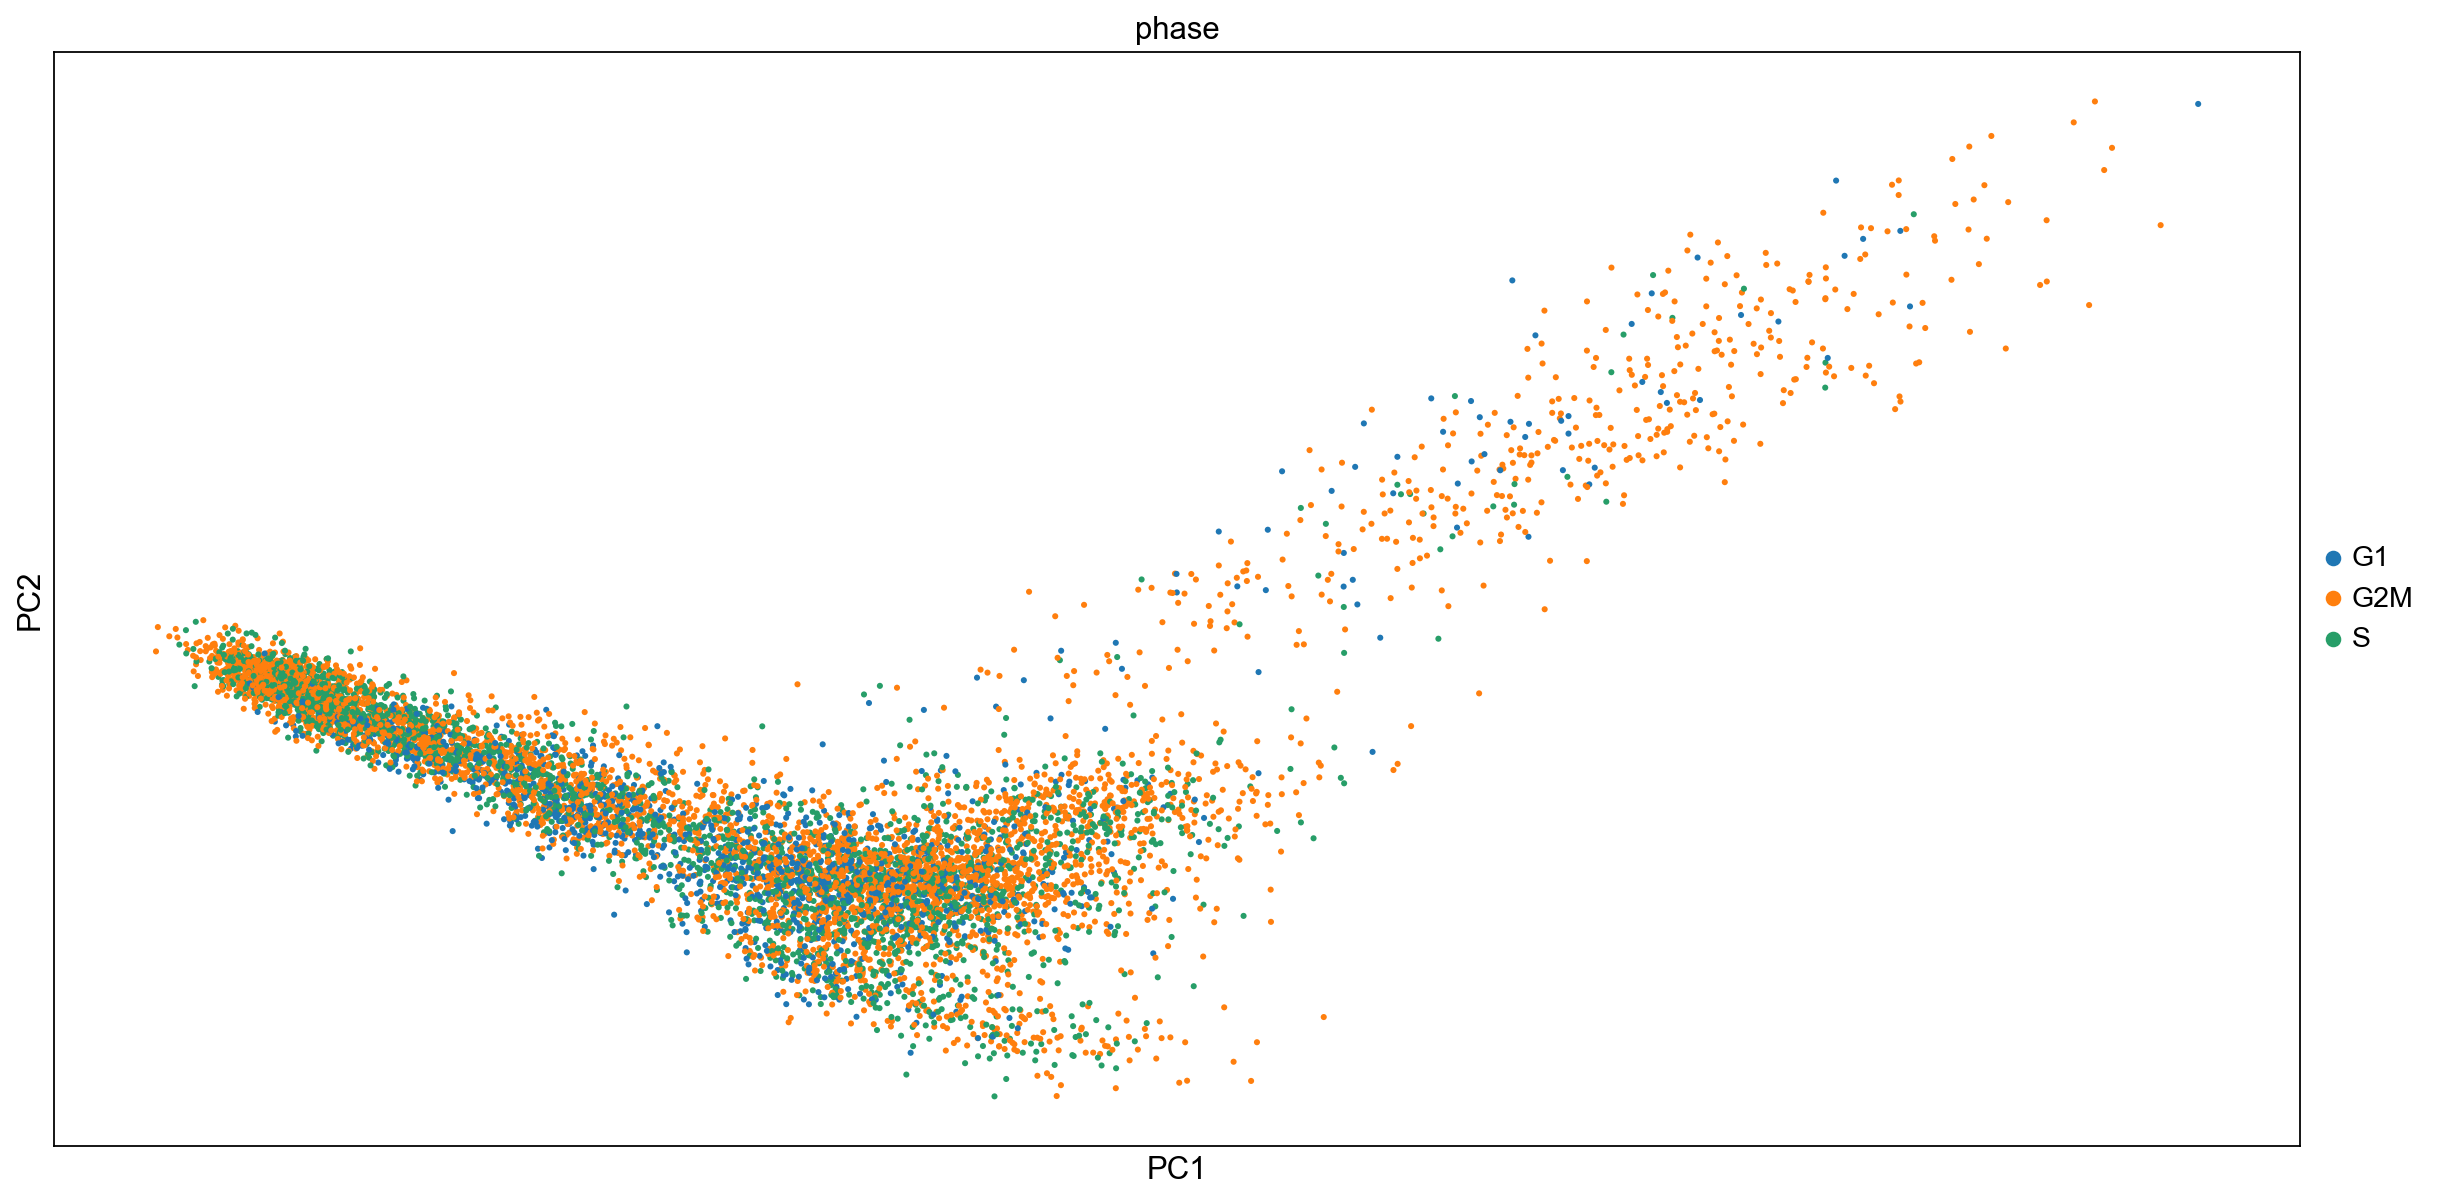

In [53]:
#sc.settings.set_figure_params(dpi=80)
copy_adata_cc_genes = filtered_copy[:, cell_cycle_genes]
sc.tl.pca(filtered_copy, svd_solver='arpack') # TODO: look at 'arpack' svd solver
sc.pl.pca(filtered_copy, color='phase', size = 30)
#Plot: PCA before regressing out cell-cycle genes

C:\Users\wroej\anaconda3\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


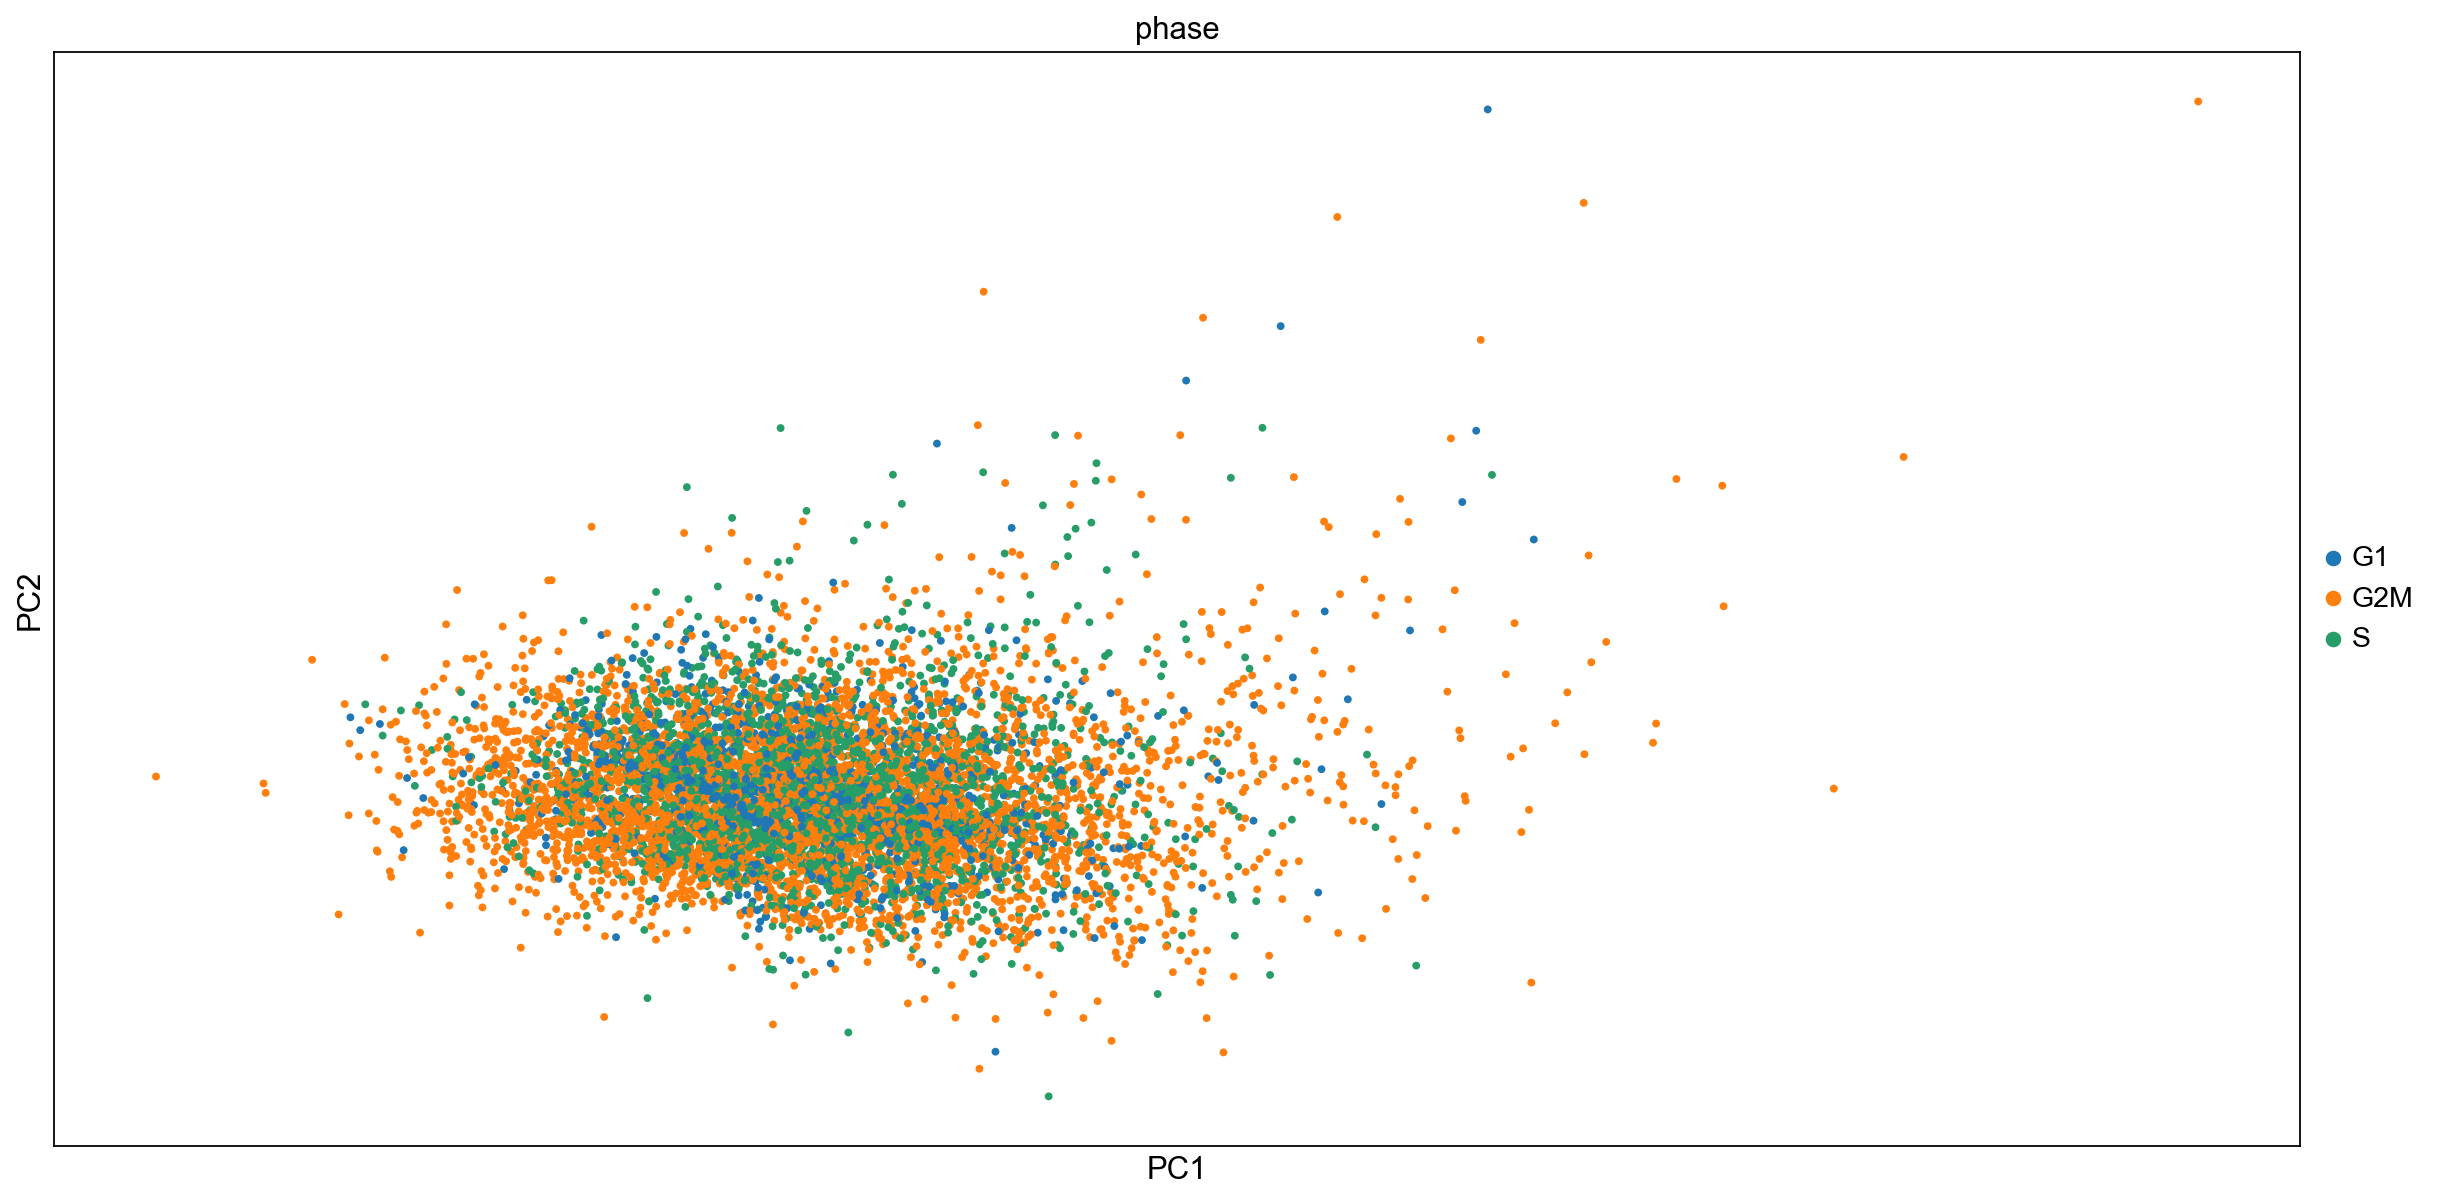

In [54]:
sc.pp.regress_out(copy_adata_cc_genes, ['S_score', 'G2M_score'])
sc.pp.scale(copy_adata_cc_genes)

#adata_cc_genes constains the data with regressed out cell-cycle effects
adata_cc_genes = copy_adata_cc_genes[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes, svd_solver='arpack')
sc.pl.pca(adata_cc_genes, color='phase', size = 50)
#Plot: PCA after regressing out cell-cycle genes

## DPT after cell cycle regression

In [55]:
adata_cc_genes.uns['iroot'] = 0
sc.pp.neighbors(adata_cc_genes, n_neighbors=15, n_pcs=14, knn=True, random_state=0, method='gauss', metric='euclidean', key_added=None, copy=False)
sc.tl.dpt(adata_cc_genes, n_dcs=14, n_branchings=0)
adata_cc_genes.obs["dpt_pseudotime"]

W29954    0.000000
W29956    0.007603
W29957    0.017667
W29958    0.062886
W29960    0.133473
            ...   
W76317    0.077611
W76324    0.035564
W76331    0.056516
W76332    0.039524
W76333    0.034973
Name: dpt_pseudotime, Length: 8100, dtype: float32

Text(0, 0.5, 'dpt_score')

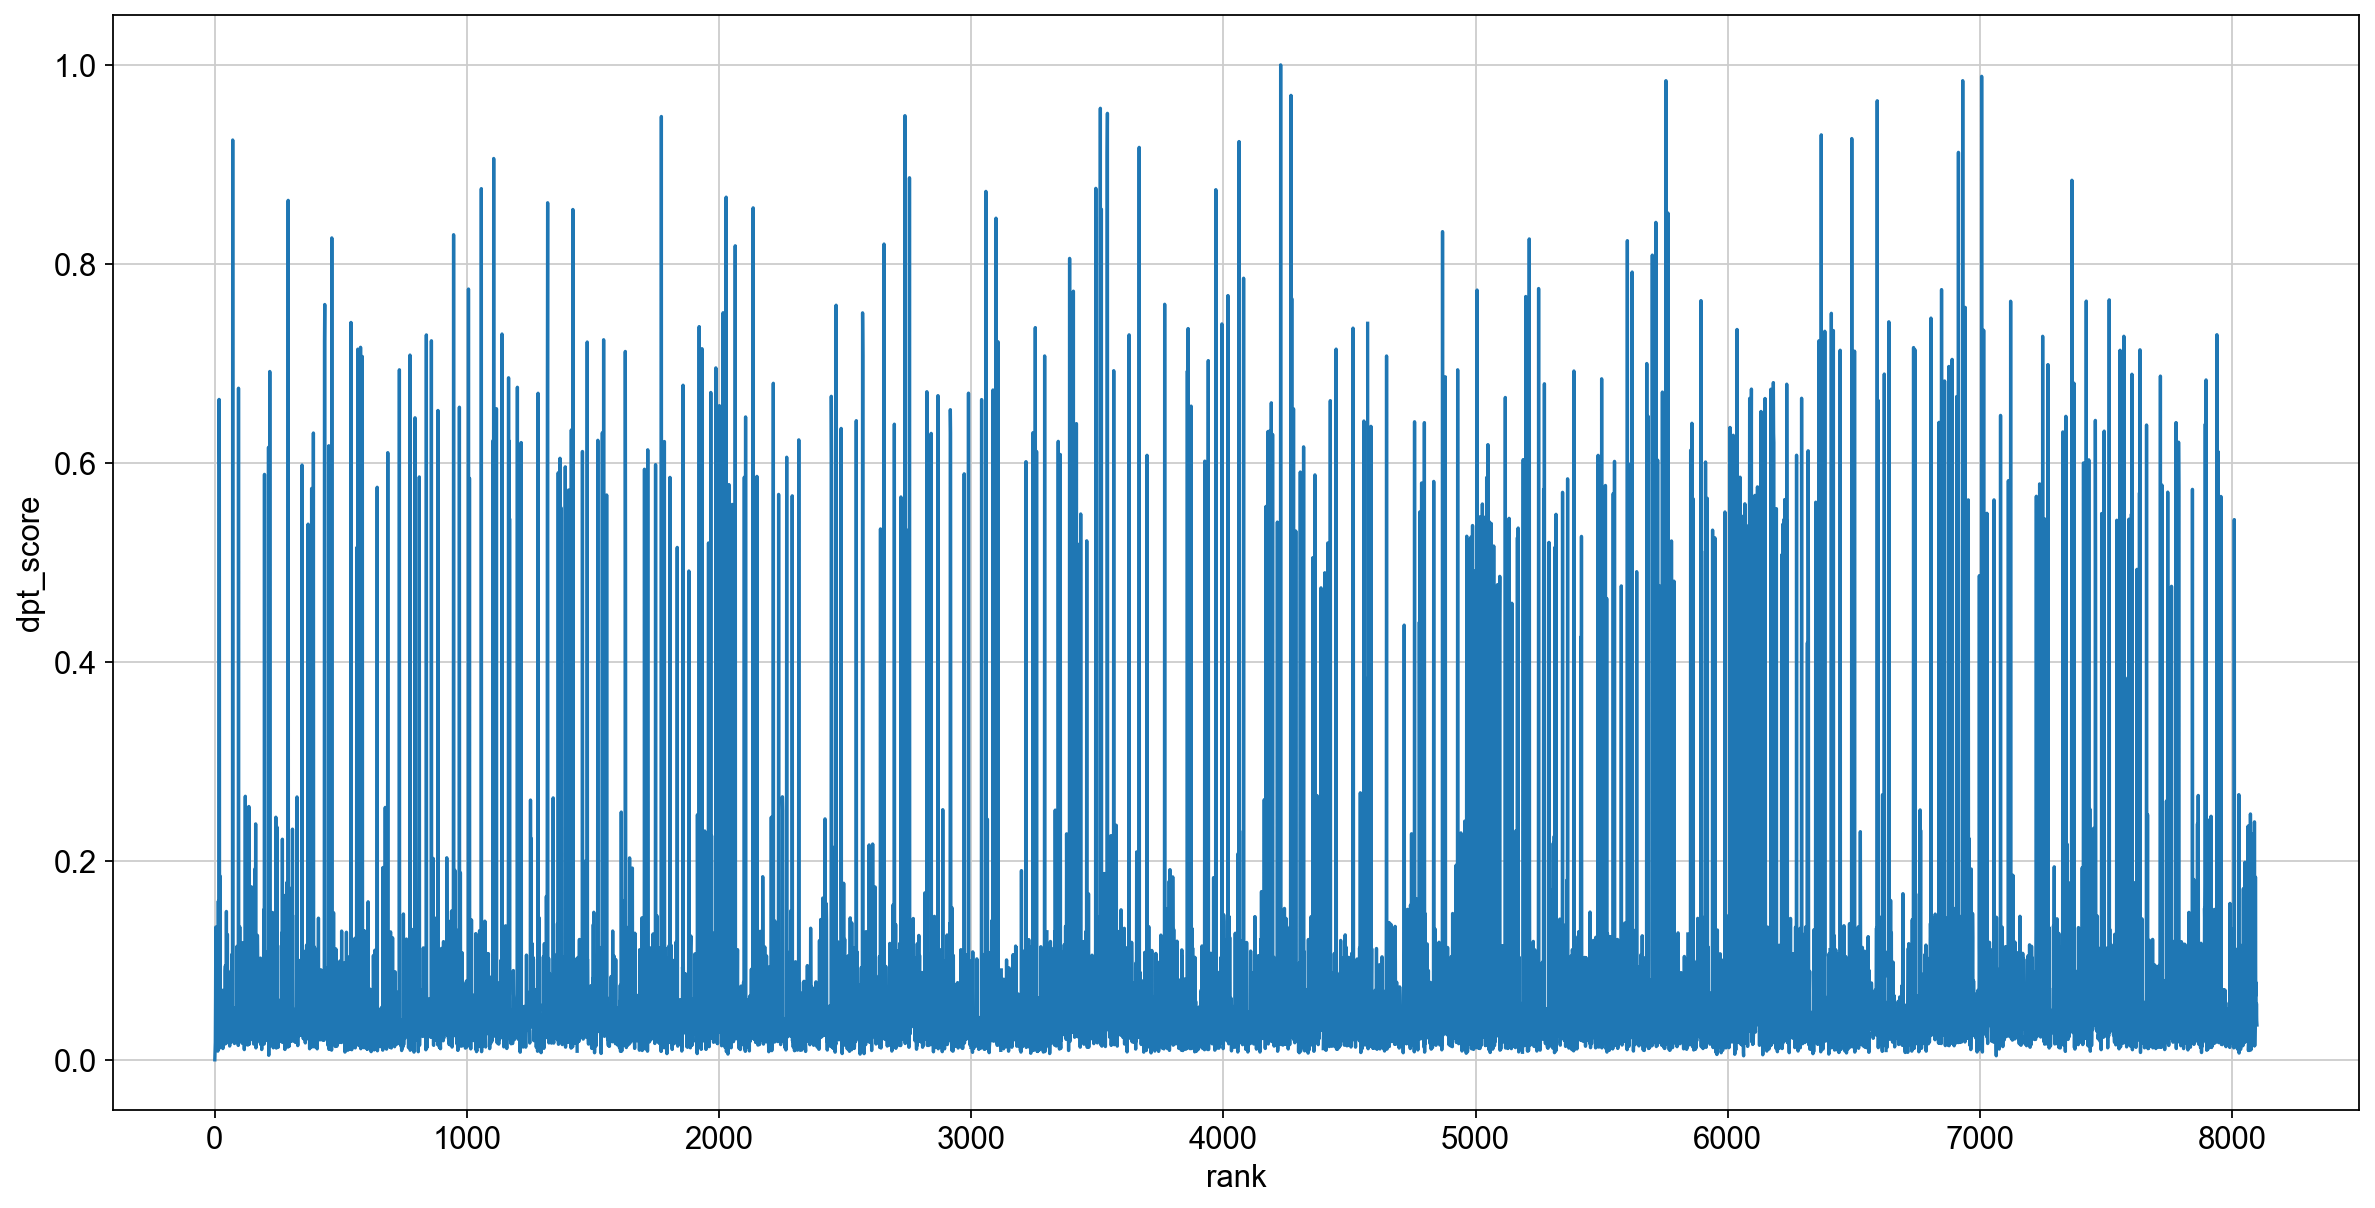

In [56]:
fig4, axs4 = plt.subplots(1, 1)

dpt_scores_after_CCR = list(adata_cc_genes.obs["dpt_pseudotime"])

axs4.plot(range(len(dpt_scores)),dpt_scores_after_CCR)
#axs[0].set_yscale("log")
axs4.set_xlabel("rank")
axs4.set_ylabel("dpt_score")

In [57]:
np.argmax(adata_cc_genes.obs["dpt_pseudotime"])

1064

In [58]:
adata_filtered.X.shape

(8100, 16162)

## Kendall rank test

In [72]:
collection_date = [list(adata_filtered.obs_names)[i][1] for i in range(adata_filtered.X.shape[0])]

#print(list(adata_filtered.obs_names)[0][0])
#print(collection_date)

sp.stats.kendalltau(collection_date,dpt_scores)

KendalltauResult(correlation=0.05974005895911589, pvalue=3.9710865352840347e-13)

In [73]:
sp.stats.kendalltau(collection_date,dpt_scores_after_CCR)

KendalltauResult(correlation=0.03675700068187643, pvalue=8.01601392464696e-06)

# Computing Neighborhood Graph

In [49]:
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=40)

# Embedding Neighborhood Graph

In [ ]:
sc.tl.louvain(adata_filtered)

In [ ]:
sc.tl.paga(adata_filtered)
sc.pl.paga(adata_filtered, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_filtered, init_pos='paga')
sc.tl.umap(adata_filtered)
sc.pl.umap(adata_filtered, color=['louvain']) #, color=['CST3', 'NKG7', 'PPBP'])

In [ ]:
# see tutorial for what raw actually does, no significant difference vs above
sc.pl.umap(adata_filtered, use_raw=False) #, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering Neighborhood Graph

In [ ]:
sc.tl.leiden(adata_filtered)
sc.pl.umap(adata_filtered, color=['leiden']) #, 'CST3', 'NKG7'])

In [ ]:
adata_filtered.write(results_file)

# Finding Marker Genes

In [ ]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [ ]:
adata_filtered.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
#sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
# adata = sc.read(results_file)
# sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
#sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
# new_cluster_names = [
#     'CD4 T', 'CD14 Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
#sc.pl.dotplot(adata, marker_genes, groupby='leiden');

# Trajectory Analysis

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

## Graph Denoising

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

## Clustering and PAGA

In [ ]:
sc.tl.louvain(adata,resolution=1.0)
sc.tl.paga(adata)
sc.pl.paga(adata) #, 'Hba-a2', 'Elane', 'Irf8'

In [ ]:
# Annotations?
# FIGURE OUT IF ANNOTATIONS ARE NECESSARY

## DPT

In [ ]:
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')